In [1]:
import os

In [2]:
DATA_DIR = './data'
print(os.listdir(DATA_DIR))

['images']


In [3]:
print(os.listdir(DATA_DIR)[:3])

['images']


Vamos carregar o dataset. Também redimensionaremos e moveremos a imagem de 64x64 px e normalizaremos os valores com media e SD de 0.5 pra cada canal.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [5]:
IMAGE_SIZE = 64
BATCH_SIZE = 128
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
train_ds = ImageFolder(
    DATA_DIR,
    transform=T.Compose(
        [
            T.Resize(IMAGE_SIZE),
            T.CenterCrop(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize(*STATS),
        ]
    ),
)

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)

Criaremos uma função para desnormalizar o tensor da imagem e mostrará alguns exemplos a partir do lote de treino

In [7]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [8]:
def denorm(img_tensors):
    return img_tensors * STATS[1][0] + STATS[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [10]:
# show_batch(train_dl)

## Configurando GPU

In [11]:
# Selecionando o dispositivo
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

# Rede Discriminadora

O discriminador pega uma imagem como entrada e tenta classificar como real ou fake. Nesse sentido, é como qualquer outra rede comum. Usaremos CNNs que retornarão um número para cada imagem. Usaremos stride de 2 para reduzir progressivamente o tamanho da saída do mapeamento de características

In [13]:
import torch.nn as nn

In [14]:
discriminator = nn.Sequential(
    # Entrada: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Saída: 64 x 32 x 32
    #
    # Entrada: 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Saída: 128 x 16 x 16
    #
    # Entrada: 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # Saída: 256 x 8 x 8
    #
    # Entrada: 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # Saída: 512 x 4 x 4
    #
    # Entrada: 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # Saída: 1 x 1 x 1
    #
    # Entrada: 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid(),
)

In [15]:
discriminator = to_device(discriminator, device)

# Rede Geradora

A entrada da rede geradora é um vetor de números aleatórios (vetor latente) que será usado como seed para a geração da imagem. O gerador converterá o tensor latente de dimensão 128 x 1 x 1 de volta em um tensor com dimensão 3 x 28 x 28. Para isso, usaremos a camada `ConvTranspose2d` do PyTorch

In [16]:
LATENT_SIZE = 128

In [17]:
generator = nn.Sequential(
    # Entrada: LATENT_SIZE x 1 x 1
    nn.ConvTranspose2d(
        LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False
    ),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Saída: 512 x 4 x 4
    #
    # Entrada: 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Saída: 256 x 8 x 8
    #
    # Entrada: 256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Saída: 128 x 16 x 16
    #
    # Entrada: 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Saída: 64 x 32 x 32
    #
    # Entrada: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh(),
    # Saída: 3 x 64 x 64
)

In [18]:
# generator = to_device(generator, device)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


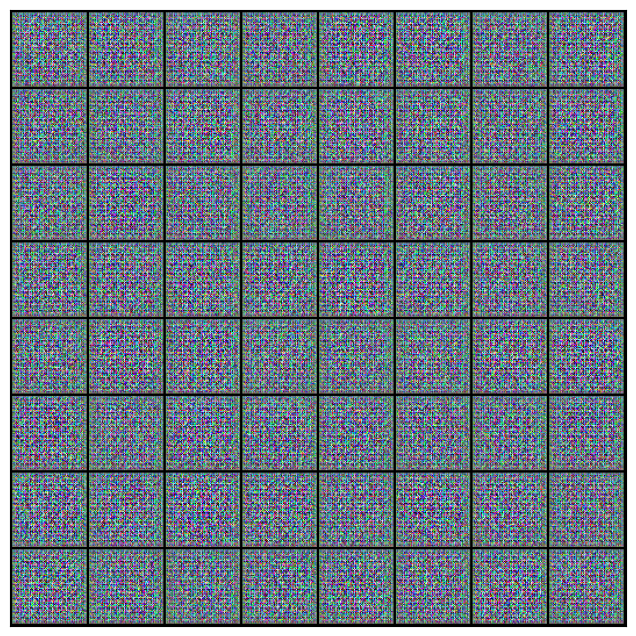

In [19]:
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1)  # (batch_size, latent_size, 1, 1)
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

# Treinamento do Discriminador

Podemos utilizar a entropia cruzada binária para avaliar o quão bem estamos discriminando

In [20]:
import torch.nn.functional as F

Os passos envolvidos no treinamento do discriminador são:

* Esperamos que o discriminador retorne 1 se a imagem pega do conjunto real, e 0 se foi gerada usando a rede geradora

* Primeiro passamos um lote de imagens reais, e calculamos a perda, configurando o alvo com rótulo 1

* Depois passamos o lote de imagens falsas (geradas pelo gerador) pelo discriminador e calculamos a perda, configurando o alvo com rótulo 0

* Finalmente adicionamos as duas perdas e usamos a perda maior para performar a descida de gradiente para ajustar os pesos do discriminador

In [21]:
def train_discriminator(real_images, opt_d):
    # Limpa os gradientes
    opt_d.zero_grad()

    # Passa as imagens reais para o discriminador
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy()(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Gera imagens falsas
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    # Passa as imagens geradas para o discriminador
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Atualiza os parâmetros do discriminador
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score

# Treinamento do Gerador

Os passos para o treinamento do gerador são:

* Geramos um lote de imagens usando o gerador e passamos pelo discriminador

* Calculamos a perda configurando os rótulos como 1 (real). Precisamos disso para ensinar o gerador a enganar o discriminador

* Usamos a perda para performar as descidas de gradiente e mudar os pesos do gerador, a fim de melhorar a sua habilidade em enganar o discriminador

In [22]:
def train_generator(opt_g):
    # Limpa os gradientes
    opt_g.zero_grad()

    # Gera imagens falsas
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    # Tenta enganar o discriminador
    preds = discriminator(fake_images)
    targets = torch.ones(BATCH_SIZE, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Atualiza os parâmetros do gerador
    loss.backward()
    opt_g.step()

    return loss.item()

Precisamos criar um diretório para salvar as saídas temporárias do gerador para inspecionar visualmente o progresso do modelo. Podemos criar uma função ajudante para exportar as imagens geradas

In [23]:
from torchvision.utils import save_image

In [24]:
SAMPLE_DIR = "generated"  # Diretório para salvar as imagens geradas
os.makedirs(SAMPLE_DIR, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(SAMPLE_DIR, fake_fname), nrow=8)
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
generator = to_device(generator, device)

In [27]:
FIXED_LATENT = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


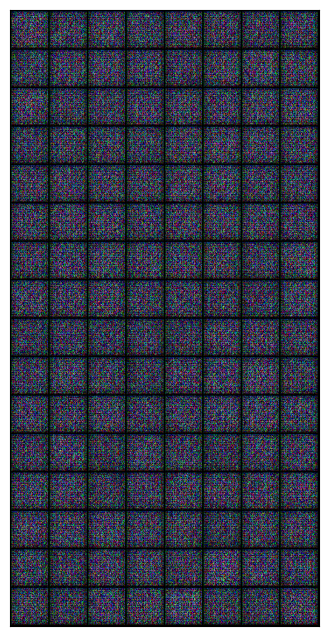

In [28]:
save_samples(0, FIXED_LATENT)

## Ciclo de Treinamento

In [30]:
from tqdm.notebook import tqdm

In [32]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Perdas e Pontuação
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Cria os otimizadores
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Treina o discriminador
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

            # Treina o gerador
            loss_g = train_generator(opt_g)

        # Salva as pontuações e perdas
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Mostra os resultados e pontuações (último lote)
        print(
            "Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch + 1, epochs, loss_g, loss_d, real_score, fake_score
            )
        )

        # Salva as imagens geradas
        save_samples(epoch + start_idx, FIXED_LATENT, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [33]:
LR = 0.0002
EPOCHS = 10